<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/videos/Practica_7_1_Regresion_Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 7.1: Modelos de Regresión logística

En esta clase vamos a ver cómo cargar nuevos modelos de regresión en `Bambi`, yendo más allá y utilizando funciones de verosimilitud que no son Normales.

Nuestro caso de aplicación de ejemplo será la regresión logística, donde lo que vamos a ajutar es la probabilidad $p$ de pertencer a una determinada categoría, y esta probabilidad depende de distintos predictores.

*Nota: Nada me impediría aplicar estos conceptos, por ejemplo, a una distribución de Poisson donde $\lambda$ depende de $x$, a una binomial, etc.*

Empecemos importando las liberías necesarias.

In [ ]:
# Instalación e import de Bambi
try:
  import bambi as bmb
except:
  !pip install bambi
  import bambi as bmb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import io
from google.colab import files

## Ejercicio: Modelado de variables de respuesta categóricas

Para este ejercicio vamos a utilizar el archivo **concrete_test.csv** que contiene distintos ensayos de hormigón y su composición. En este ejemplo vamos a hacernos la siguiente pregunta:

- Si me dan las propiedades de un hormigón, ¿puedo identificar si continene escoria de alto horno o no?

Para contestar esa pregunta, lo que haremos será construir un modelo que prediga la probabilidad de contenter escoria en función de otras variables predictoras.

### Carga de Datos

In [ ]:
#Abrimos un archivo local, es decir, que ha sido descargado en su computadora
uploaded = files.upload()

Saving concrete_tests.csv to concrete_tests.csv


In [ ]:
#Se crea un DataFrame
df_hormigon = pd.read_csv(io.BytesIO(uploaded['concrete_tests.csv']))
df_hormigon.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [ ]:
# Vemos el tipo de dato y si existen nulos
df_hormigon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Cement                              103 non-null    float64
 1   Slag                                103 non-null    float64
 2   Fly ash                             103 non-null    float64
 3   Water                               103 non-null    float64
 4   SP                                  103 non-null    float64
 5   Coarse Aggr.                        103 non-null    float64
 6   Fine Aggr.                          103 non-null    float64
 7   SLUMP(cm)                           103 non-null    float64
 8   FLOW(cm)                            103 non-null    float64
 9   Compressive Strength (28-day)(Mpa)  103 non-null    float64
dtypes: float64(10)
memory usage: 8.2 KB


In [ ]:
df_hormigon.rename(columns={
  'Fly ash': "Fly_ash",
  'SP': "Superplasticizer",
  'Coarse Aggr.': "Coarse_aggr",
  'Fine Aggr.': "Fine_aggr",
  'SLUMP(cm)': 'Slump_cm',
  'FLOW(cm)': 'Flow_cm',
  'Compressive Strength (28-day)(Mpa)': "CompressiveStrength"
                     },
            inplace=True)

### Ejemplo: Regresión logística

Primero, definiremos la variable categórica `escoria` que indica si hay presencia de escoria en la dosificación (`True`) o no (`False`). Luego, como sabemos que un parámetro fundamental de las dosificaciones de hormigón es la relación `agua-material cementicio`, crearemos la variable `a_c`.

In [ ]:
# Nuevas Variables
df_hormigon['escoria'] = (df_hormigon['Slag']!=0)
df_hormigon['a_c'] = (df_hormigon['Water']/(df_hormigon['Cement']+df_hormigon['Fly_ash']+df_hormigon['Slag']))

df_hormigon.head()

,Cement,Slag,Fly_ash,Water,Superplasticizer,Coarse_aggr,Fine_aggr,Slump_cm,Flow_cm,CompressiveStrength,escoria,a_c
0,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99,True,0.456522
1,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14,True,0.357853
2,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81,True,0.357285
3,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08,True,0.358000
4,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82,True,0.536585


#### EDA

A fines didácticos, se presenta un simple pair-plot con las variables que se van a tener en cuenta en este problema:

- `a_c`: relación agua-material cementicio
- `slump_cm`: asentamiento de la muestra
- `CompressiveStrength`: resistencia a 28 días.

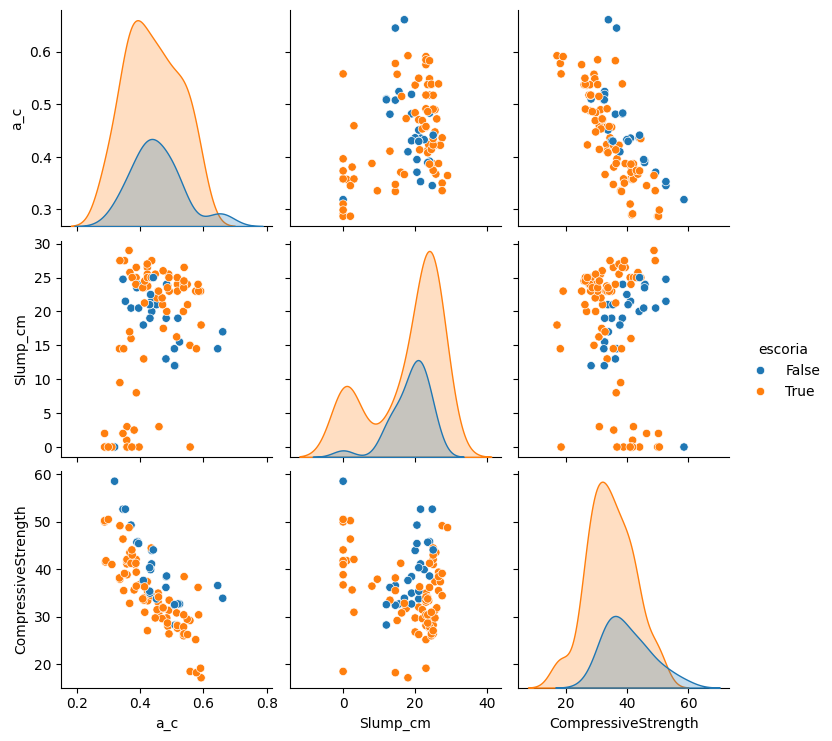

In [ ]:
# Grilla de gráficos de puntos
sns.pairplot(df_hormigon[['a_c','Slump_cm','CompressiveStrength','escoria']],hue='escoria')
plt.show()

Pareciera verse que la presencia de escoria es distinguible en las variables predictoras, particularmente en el gráfico resistencia a la compresión/a-c)

#### Modelado


Nuestro objetivo final es, utilizando nuestro entendimiento del problema, modelar Y con uno o más de los predictores anteriores.

De manera similar a como hicimos en clases anteriores, tenemos que indicarle a bambi:
- Las prioris,
- El DataFrame con los datos,
- La familia: **Bernoulli** ya que Y es un indicador binario de algún evento de interés que ocurre con una cierta probabilidad
- la fórmula: igual que siempre, considerando que se aplica la transformación logit()

##### Modelo 1 (simple)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength)}}$$

In [ ]:
model_1 = bmb.Model("escoria ~ scale(a_c) + scale(Slump_cm) + scale(CompressiveStrength)", df_hormigon, family="bernoulli")
fitted_1 = model_1.fit(draws=2000, chains=4)

Output()

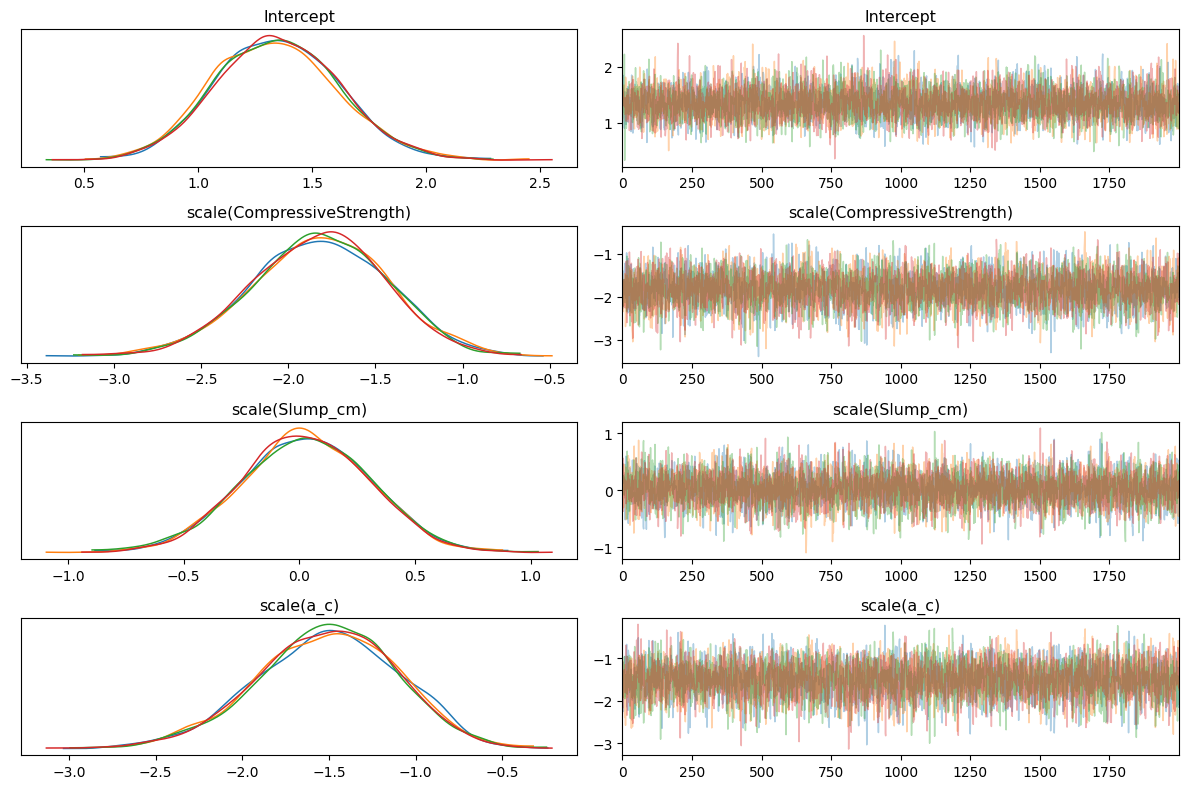

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.347,0.272,0.842,1.852,0.003,0.003,6521.0,5253.0,1.0
scale(CompressiveStrength),-1.823,0.391,-2.545,-1.072,0.006,0.004,4714.0,5449.0,1.0
scale(Slump_cm),0.026,0.279,-0.495,0.542,0.003,0.003,6628.0,5566.0,1.0
scale(a_c),-1.514,0.408,-2.309,-0.782,0.006,0.004,4874.0,5047.0,1.0


In [ ]:
az.plot_trace(fitted_1,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_1)

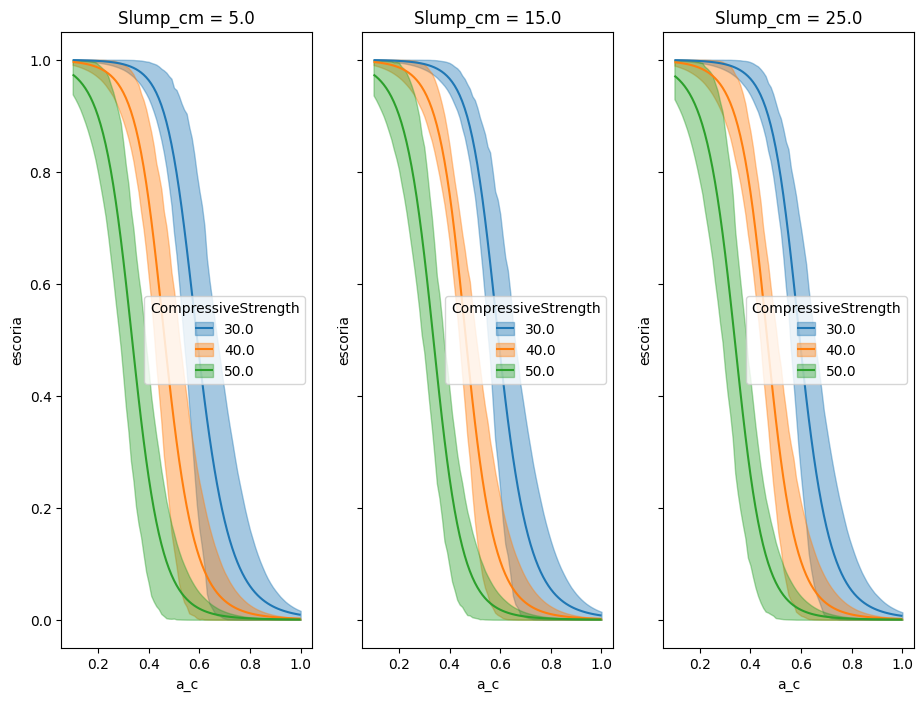

In [ ]:
bmb.interpret.plot_predictions(model_1,fitted_1,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 40, 50],
                               'Slump_cm':[5,15,25]},prob=0.9,fig_kwargs=dict(figsize=(11, 8), sharey=True))
plt.show()

##### Modelo 1b (sin asentamiento)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + D \cdot CompressiveStrength \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + D \cdot CompressiveStrength)}}$$

In [ ]:
model_1b = bmb.Model("escoria ~ scale(a_c) + scale(CompressiveStrength)", df_hormigon, family="bernoulli")
fitted_1b = model_1b.fit(draws=2000, chains=4)

Output()

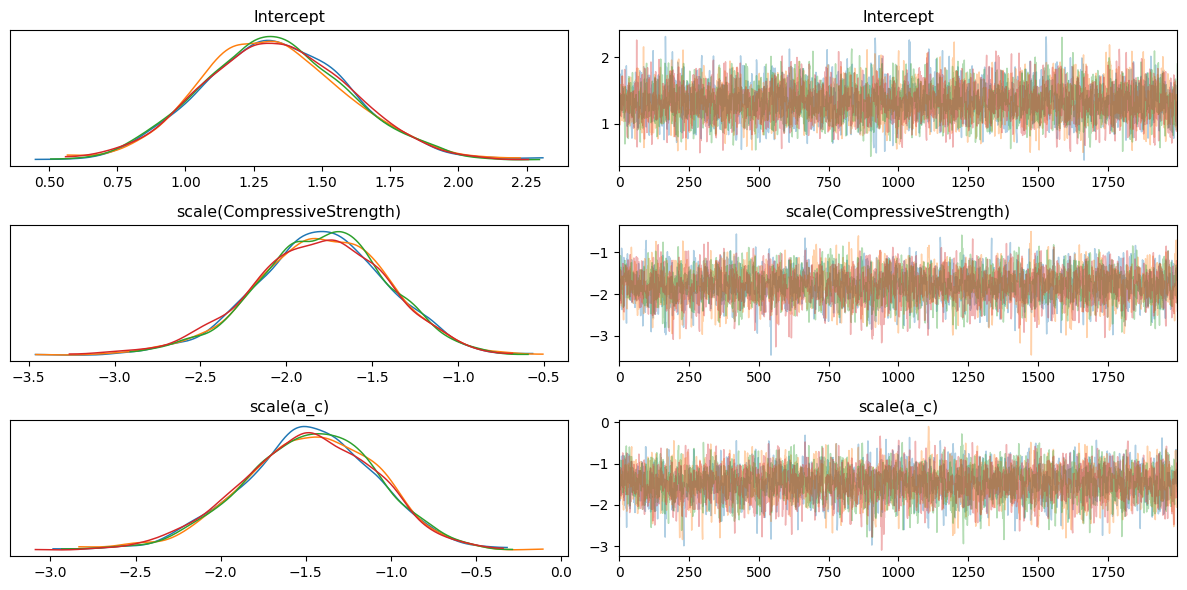

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.329,0.266,0.845,1.840,0.004,0.003,4681.0,4728.0,1.0
scale(CompressiveStrength),-1.799,0.384,-2.528,-1.082,0.006,0.005,4023.0,4467.0,1.0
scale(a_c),-1.480,0.394,-2.217,-0.755,0.006,0.005,3971.0,4408.0,1.0


In [ ]:
az.plot_trace(fitted_1b,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_1b)

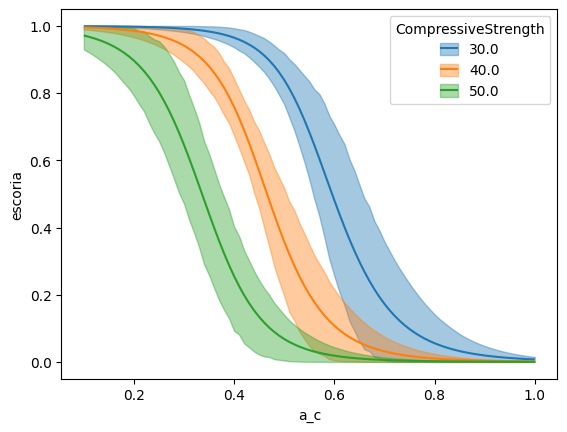

In [ ]:
bmb.interpret.plot_predictions(model_1b,fitted_1b,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 40, 50]},prob=0.9)
plt.show()

##### Modelo 2 (Interacciones)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength  \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + C \cdot Slump\_cm + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength)}}$$

In [ ]:
model_2 = bmb.Model("escoria ~ scale(a_c)*scale(CompressiveStrength) + scale(Slump_cm)", df_hormigon, family="bernoulli")
fitted_2 = model_2.fit(draws=2000, chains=4)

Output()

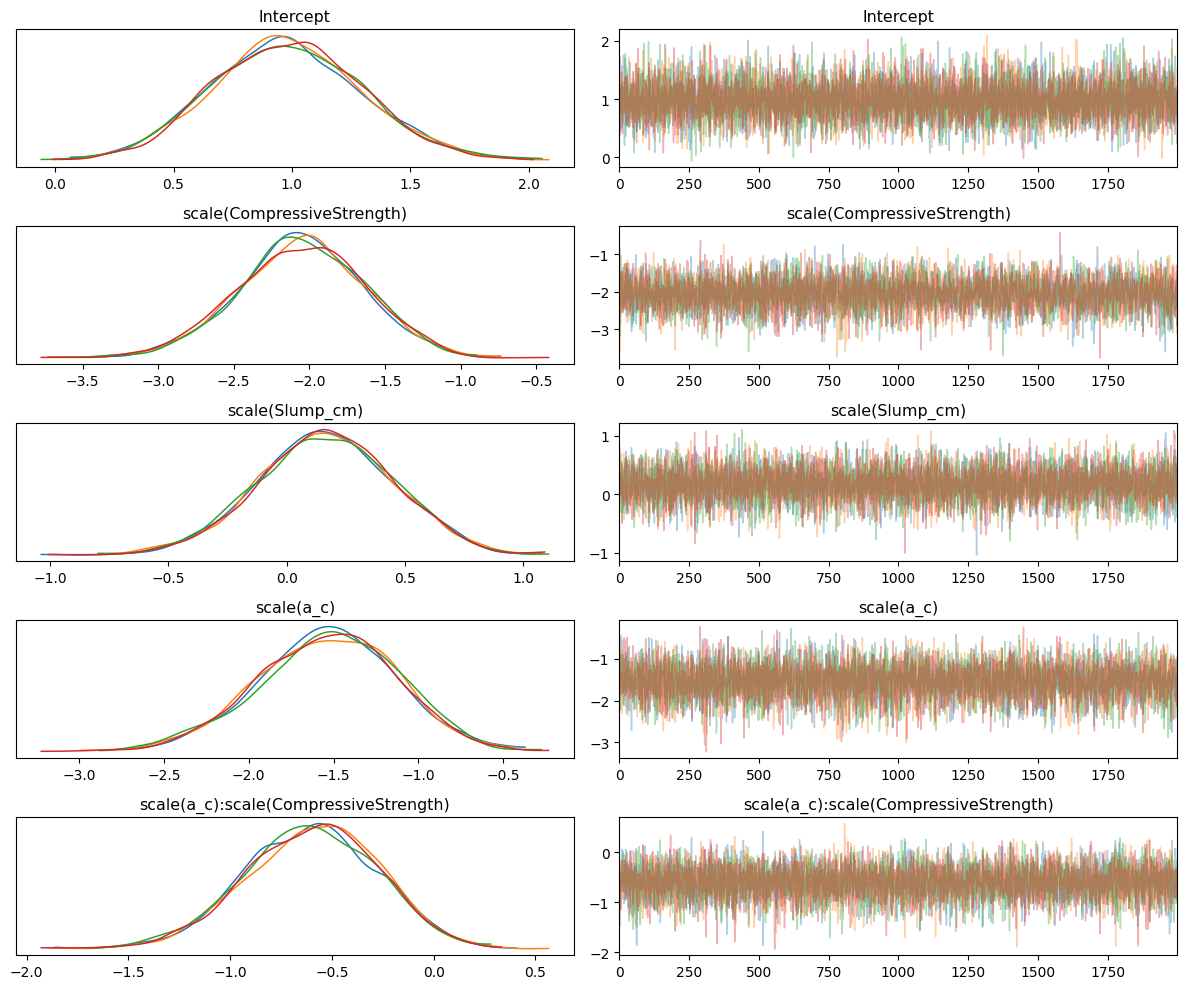

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.981,0.322,0.375,1.581,0.003,0.003,8636.0,5877.0,1.0
scale(CompressiveStrength),-2.053,0.420,-2.827,-1.248,0.006,0.005,5755.0,5738.0,1.0
scale(Slump_cm),0.164,0.286,-0.382,0.689,0.003,0.003,7656.0,5923.0,1.0
scale(a_c),-1.538,0.414,-2.313,-0.757,0.005,0.004,6655.0,6218.0,1.0
scale(a_c):scale(CompressiveStrength),-0.603,0.327,-1.218,-0.005,0.004,0.003,6893.0,5860.0,1.0


In [ ]:
az.plot_trace(fitted_2,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_2)

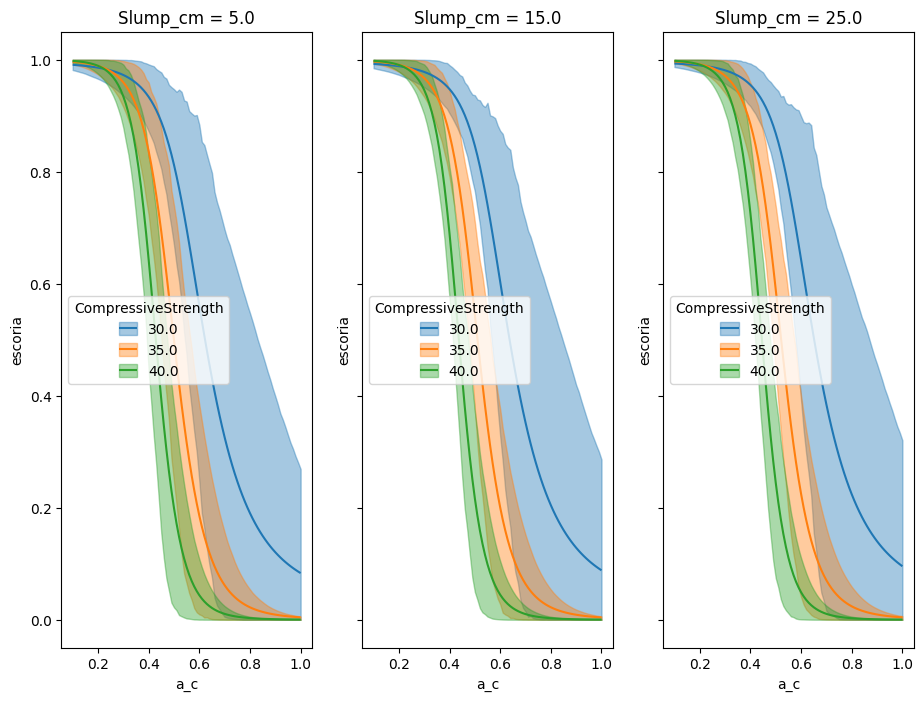

In [ ]:
bmb.interpret.plot_predictions(model_2,fitted_2,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 35, 40],
                               'Slump_cm':[5,15,25]},prob=0.9,fig_kwargs=dict(figsize=(11, 8), sharey=True))
plt.show()

##### Modelo 2b (sin asentamiento)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot a\_c + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength  \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot a\_c + D \cdot CompressiveStrength + E \cdot a\_c \cdot CompressiveStrength)}}$$

In [ ]:
model_2b = bmb.Model("escoria ~ scale(a_c)*scale(CompressiveStrength)", df_hormigon, family="bernoulli")
fitted_2b = model_2b.fit(draws=2000, chains=4)

Output()

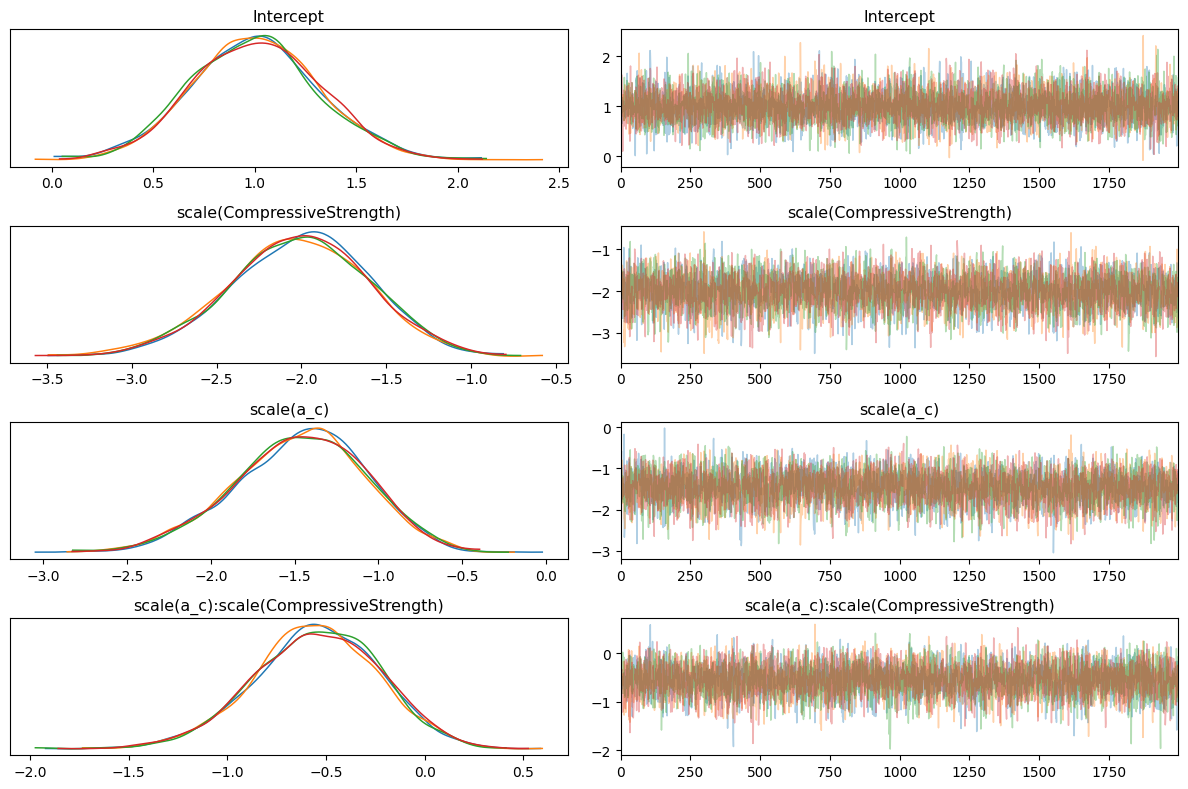

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.006,0.318,0.411,1.608,0.004,0.003,7843.0,6319.0,1.0
scale(CompressiveStrength),-2.016,0.412,-2.827,-1.272,0.006,0.005,4732.0,4962.0,1.0
scale(a_c),-1.469,0.394,-2.219,-0.741,0.005,0.004,5407.0,5439.0,1.0
scale(a_c):scale(CompressiveStrength),-0.551,0.321,-1.140,0.060,0.004,0.004,6160.0,5740.0,1.0


In [ ]:
az.plot_trace(fitted_2b,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_2b)

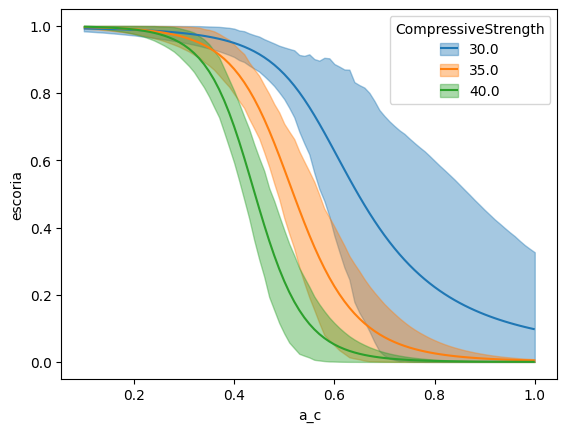

In [ ]:
bmb.interpret.plot_predictions(model_2b,fitted_2b,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 35, 40]},prob=0.9)
plt.show()

##### Modelo 3 (logaritmos)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot \log(a\_c) + C \cdot Slump\_cm+ D \cdot \log(CompressiveStrength) \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot \log(a\_c) + C \cdot Slump\_cm+ D \cdot \log(CompressiveStrength))}}$$

In [ ]:
model_3 = bmb.Model("escoria ~ scale(Slump_cm) + scale(log(a_c)) + scale(log(CompressiveStrength))", df_hormigon, family="bernoulli")
fitted_3 = model_3.fit(draws=2000, chains=4)

Output()

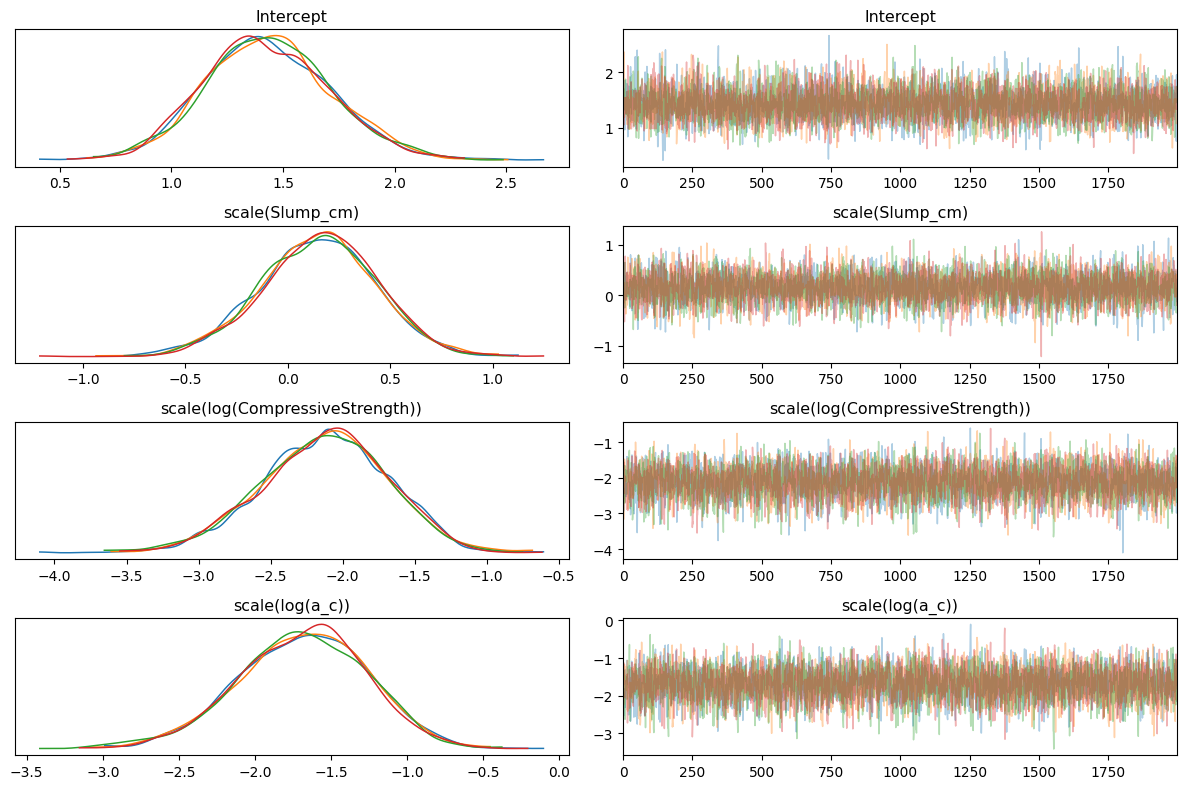

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.432,0.282,0.928,1.980,0.004,0.003,5635.0,5288.0,1.0
scale(Slump_cm),0.150,0.281,-0.393,0.663,0.004,0.003,6407.0,5633.0,1.0
scale(log(CompressiveStrength)),-2.126,0.437,-2.980,-1.358,0.006,0.005,4837.0,5351.0,1.0
scale(log(a_c)),-1.690,0.424,-2.458,-0.871,0.006,0.005,5039.0,5416.0,1.0


In [ ]:
az.plot_trace(fitted_3,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_3)

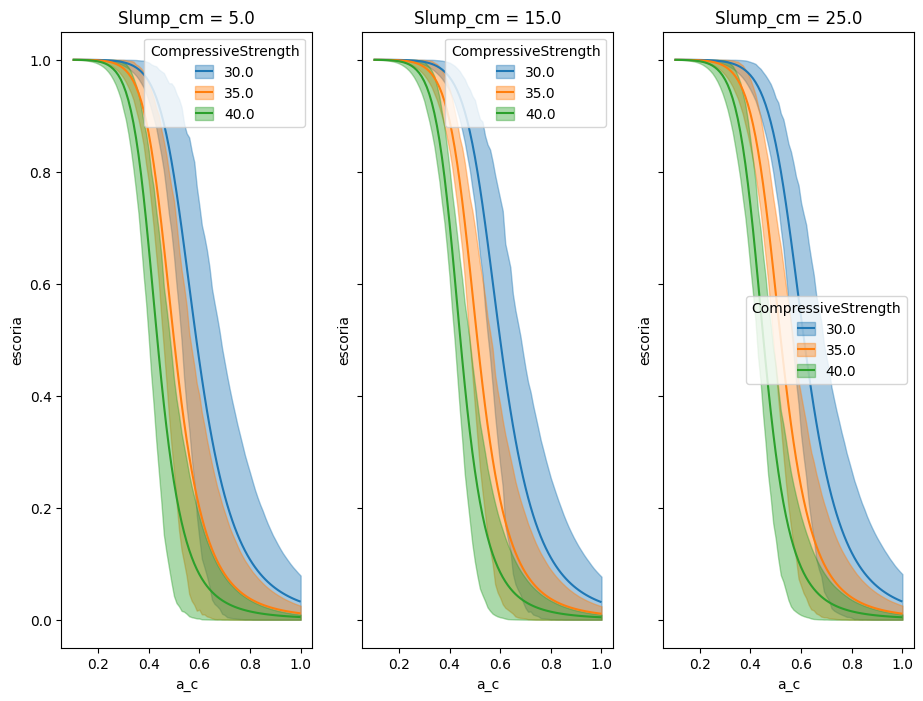

In [ ]:
bmb.interpret.plot_predictions(model_3,fitted_3,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 35, 40],
                               'Slump_cm':[5,15,25]},prob=0.9,fig_kwargs=dict(figsize=(11, 8), sharey=True))
plt.show()

##### Modelo 3b (sin asentamiento)

En este caso, estamos proponiendo que:

$$Y \sim Bernoulli \left(logit(p_{escoria}) = A + B \cdot \log(a\_c) + D \cdot \log(CompressiveStrength) \right)$$

Noten que el `link` por default para una `bernoulli` es el logit, así que $p_{escoria}$ se calcula como:

$$p_{escoria} = \frac{1}{1+e^{-(A + B \cdot \log(a\_c) + D \cdot \log(CompressiveStrength))}}$$

In [ ]:
model_3b = bmb.Model("escoria['True'] ~ scale(log(a_c)) + scale(log(CompressiveStrength))", df_hormigon, family="bernoulli")
fitted_3b = model_3b.fit(draws=2000, chains=4)

Output()

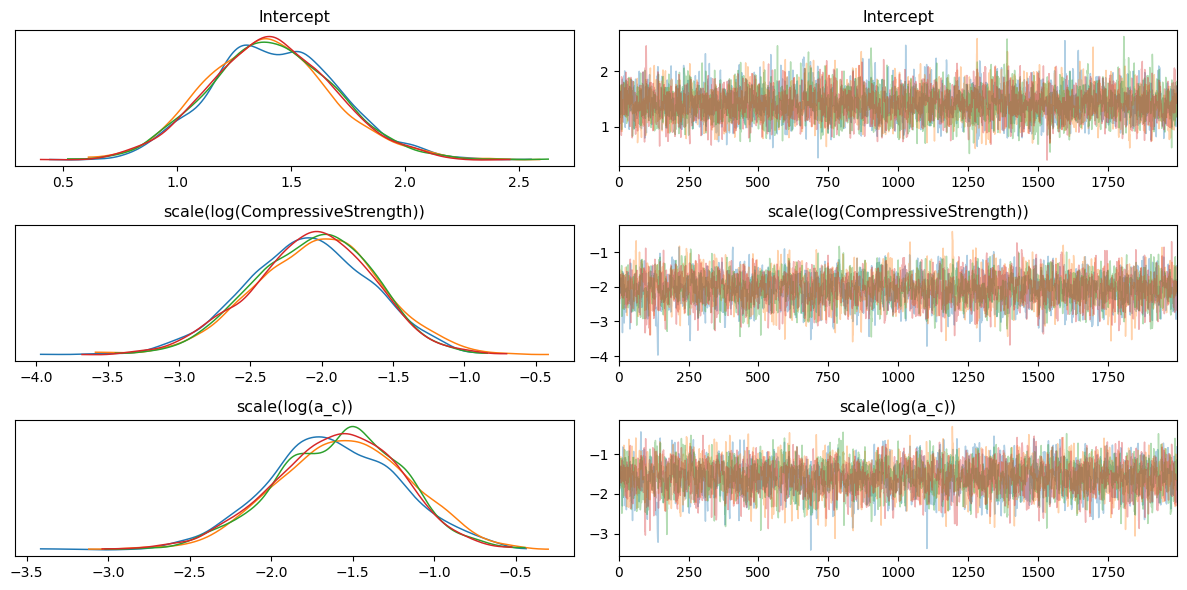

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.416,0.279,0.879,1.921,0.004,0.003,4500.0,5081.0,1.0
scale(log(CompressiveStrength)),-2.068,0.436,-2.856,-1.224,0.008,0.005,3137.0,4101.0,1.0
scale(log(a_c)),-1.592,0.401,-2.350,-0.855,0.007,0.005,3287.0,4632.0,1.0


In [ ]:
az.plot_trace(fitted_3b,compact=False);
plt.tight_layout()
plt.show()

az.summary(fitted_3b)

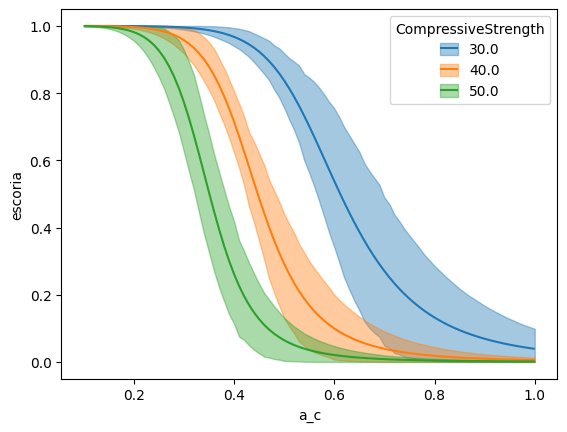

In [ ]:
bmb.interpret.plot_predictions(model_3b,fitted_3b,conditional={'a_c':np.linspace(0.1,1,91),'CompressiveStrength':[30, 40, 50]},prob=0.9)
plt.show()

#### Comparando los modelos

Como ya vimos, con `Arviz` podemos comparar la capacidad predictiva 'out-of-sample' estimada de los modelos para elegir:

In [ ]:
model_1.compute_log_likelihood(fitted_1)
model_2.compute_log_likelihood(fitted_2)

model_1b.compute_log_likelihood(fitted_1b)
model_2b.compute_log_likelihood(fitted_2b)

model_3.compute_log_likelihood(fitted_3)
model_3b.compute_log_likelihood(fitted_3b)

models_dict = {
    "model_1": fitted_1,
    "model_2": fitted_2,
    "model_1b": fitted_1b,
    "model_2b": fitted_2b,
    "model_3": fitted_3,
    "model_3b": fitted_3b}

df_compare = az.compare(models_dict)
df_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_3b,0,-42.386032,2.092460,0.000000,1.000000e+00,4.682021,0.000000,False,log
model_3,1,-42.707453,2.655050,0.321421,3.330669e-15,4.684784,0.391690,False,log
model_2b,2,-43.336559,2.916543,0.950527,0.000000e+00,4.999226,0.723115,False,log
model_2,3,-43.684598,3.491988,1.298565,0.000000e+00,4.954650,0.782448,False,log
model_1b,4,-44.522700,2.159324,2.136668,0.000000e+00,4.937548,0.913009,False,log
model_1,5,-45.187802,2.726744,2.801770,0.000000e+00,5.002186,0.965852,False,log


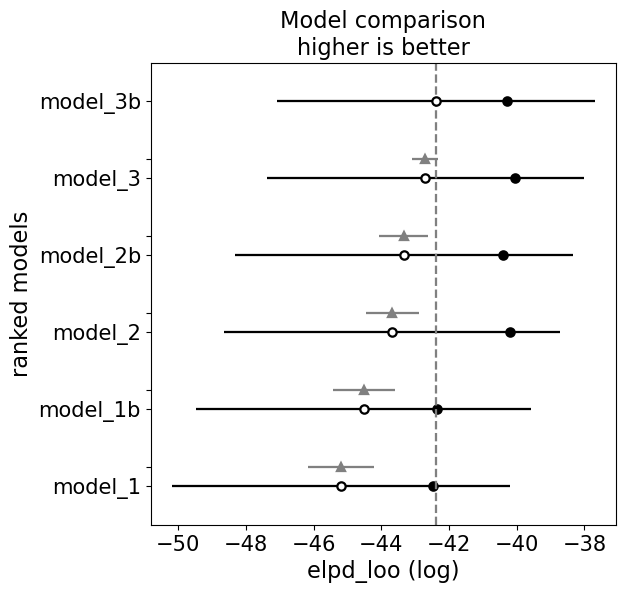

In [ ]:
az.plot_compare(df_compare, insample_dev=True,plot_ic_diff=True);

Y con esto podríamos elegir un modelo entre los que planteamos. ¿Cuál usarían ustedes?

#### Uso del modelo

Ahora que tenemos un modelo, podemos usarlo para predecir la presencia de escoria, y también para analizar un poco mejor cómo funciona.

Para ello, igual que siempre, vamos a simular valores de probabilidad para datos no vistos.

Tomemos el siguiente hormigón hormigón:

- a/c: 0.4; fc=40MPa
- a/c: 0.5; fc=40MPa

Primero, genero un nuevo dataframe:

In [ ]:
df_nuevo = pd.DataFrame({'a_c':[0.4,0.5],'CompressiveStrength':[40,40]})
df_nuevo.head()

,a_c,CompressiveStrength
0,0.4,40
1,0.5,40


Luego, predigo la probabilidad de escoria:

In [ ]:
results = model_3b.predict(fitted_3b,kind='response_params',data=df_nuevo,inplace=False)
results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

¡Y simplemente grafico el histograma de simulaciones!

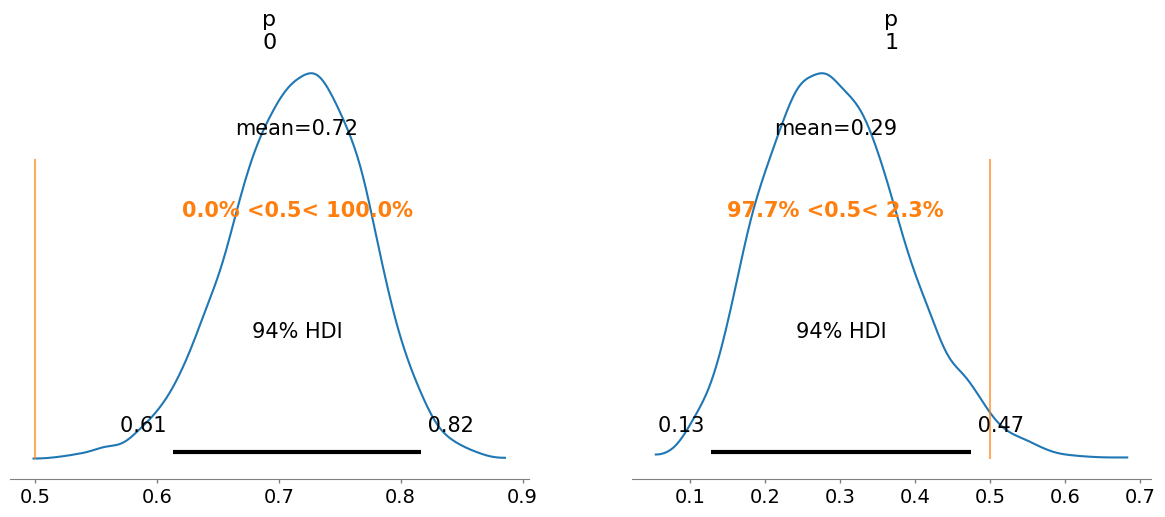

In [ ]:
az.plot_posterior(results,var_names=['p'],ref_val=0.5)
plt.show()

Tengan cuidado que el modelo define probabilidades. La decisión final de "predecir o no" la presencia de escoria es una decisión del modelador (¿a partir de qué probabilidad distingo entre sí y no? La respuesta no siempre es obvia --> Medicina, detección de zonas potenciales de tornados, etc.). El criterio de decisión hay que adoptarlo en función de otras métricas (error de tipo I, tipo II, etc.).

#### Diagnóstico

##### Matriz de confusión

La matriz de confusión es una tabla que nos indica cuántas veces el modelo acierta al simular la presencia de escoria (TP: True Positives y TN: True Negatives) y cuántas veces erra (FP: False Positives y FN: False Negatives). Representa una forma rápida de evaluar cómo funciona el modelo.

El modelo "perfecto" o ideal devolvería una matriz diagonal, sin errores de predicción.

*NOTA*: En este caso, estamos considerando sólamente el resultado de la posterior predictiva, considerando $50\%$ como el umbral decisión. Como comentamos antes, el mismo puede ser arbitrariamente modificado según las necesidades del problema.

In [ ]:
# Valores Predichos
y_pred = model_3b.predict(fitted_3b,inplace=False,kind='response')
y_pps = []
# Posterior Predictiva
for i in range(y_pred.posterior_predictive['escoria'].shape[-1]):
  y_pps.append(pd.value_counts(y_pred.posterior_predictive['escoria'][:,:,i].values.reshape((-1))).index[0])

# Valor Real
y_true = y_pred.observed_data['escoria'].values

# Creamos un nuevo DataFrame
df_results = pd.DataFrame({'Actual': y_true, 'Predicted': y_pps})
df_results['Predicted']= df_results['Predicted'].astype("category")
df_results['Predicted'] =df_results['Predicted'].cat.rename_categories({0:'s/escoria',1:'c/escoria'})
df_results['Actual']= df_results['Actual'].astype("category")
df_results['Actual'] =df_results['Actual'].cat.rename_categories({0:'s/escoria',1:'c/escoria'})

# Calculamos la matriz de confusión
confusion_matrix = pd.crosstab(df_results['Actual'], df_results['Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix

/tmp/ipython-input-1714561885.py:6: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  y_pps.append(pd.value_counts(y_pred.posterior_predictive['escoria'][:,:,i].values.reshape((-1))).index[0])


Predicted,s/escoria,c/escoria
Actual,,
s/escoria,14,12
c/escoria,4,73


##### Métricas

Luego, tenemos distintas métricas para cuantificar la bondad del modelo. Entre ellas tenemos:

- La precisión (¿En qué porcentaje acierto?):
$$\frac{TP + TN}{TP + TN + FP + FN}$$

- La sensibilidad (¿Logro detectar la escoria?):
$$\frac{TP}{TP + FN}$$

- La especificidad (¿Logro identificar que no hay escoria?):
$$\frac{TN}{TN + FP}$$

In [ ]:
fn = np.sum(df_results[df_results['Actual']=='c/escoria']['Predicted']!='c/escoria')
fp = np.sum(df_results[df_results['Actual']!='c/escoria']['Predicted']=='c/escoria')
tp = np.sum(df_results[df_results['Actual']=='c/escoria']['Predicted']=='c/escoria')
tn = np.sum(df_results[df_results['Actual']!='c/escoria']['Predicted']!='c/escoria')

Acc = (tp+tn)/(tp+tn+fp+fn)
Sen = tp/(tp+fn)
Spe = tn/(tn+fp)
print('Precision (Modelo 1)',round(Acc*100,2),'%')
print('Sensibilidad (Modelo 1)',round(Sen*100,2),'%')
print('Especificidad (Modelo 1)',round(Spe*100,2),'%')

Precision (Modelo 1) 84.47 %
Sensibilidad (Modelo 1) 94.81 %
Especificidad (Modelo 1) 53.85 %


Pueden ver aquí que este es un modelo que "en general" predice bien, pero entrando más en detalle se puede ver que es porque tiende a predecir que hay escoria. En realidad, ¡tiene bastante error a la hora de detectar que no hay!

Este balance entre error de tipo I y error de tipo II puede modificarse cambiando el umbral de decisión (a partir de qué probabilidad posterior asigno una categoría), según el interés del caso particular.